In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import segyio # to read seismic
from pathlib import Path
import random
import tensorflow as tf
import cv2

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose   
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, History
from keras import backend as K
from sklearn.model_selection import train_test_split

# what is the current directory?
current_dir = os.getcwd()
current_dir

'C:\\Users\\jkuhn\\Documents\\organized\\geohackathon\\2023'

# importing input training dataset without AGC

In [2]:
pathlist = Path(current_dir).glob('**/*_full.sgy')
all_dataset_seismic = []
for path in pathlist:   # iterating through the list of seismic data
    # because path is object not string
    path_in_str = str(path)
    #print(path_in_str)
    with segyio.open(path_in_str, 'r', ignore_geometry = True) as segyfile:
        data = segyfile.trace.raw[:]
        all_dataset_seismic.append(data)

In [3]:
seismic_dataset = [all_dataset_seismic[i] for i in [0,1,3,4,5,6,7]]  ## for training dataset
unseen_seismic_dataset = all_dataset_seismic[2]  # keeping unseen dataset with unknown ground truth

In [4]:
del all_dataset_seismic

# Aligning seismic dataset to inversion dataset

In [5]:
# clipping the seismic training dataset based on the extents from the inversion
# ranges are based on the pdf document provided and the ranges as displayed in OpendTect divided by two for TWT
seismic_dataset[0] = seismic_dataset[0].T[300:1101,15450:20166]
seismic_dataset[1] = seismic_dataset[1].T[500:1101,10475:18801]
seismic_dataset[2] = seismic_dataset[2].T[500:1101,10470:18251]
seismic_dataset[3] = seismic_dataset[3].T[500:1101,7000:13951]
seismic_dataset[4] = seismic_dataset[4].T[500:1101,8475:10951]
seismic_dataset[5] = seismic_dataset[5].T[500:1101,2800:6801]
seismic_dataset[6] = seismic_dataset[6].T[500:1101,4400:7276]

In [6]:
for dataset in seismic_dataset:
    print(np.shape(dataset))

(801, 4716)
(601, 8326)
(601, 7781)
(601, 6951)
(601, 2476)
(601, 4001)
(601, 2876)


# Importing Acoustic Inversion dataset

In [8]:
pathlist = Path(current_dir).glob('**/*_AcousticImpedance.sgy')
acoustic_impedance_dataset = []
for path in pathlist:   # iterating through the list of seismic data
    # because path is object not string
    path_in_str = str(path)
    with segyio.open(path_in_str, 'r') as segyfile:
        data = segyfile.trace.raw[:]
        acoustic_impedance_dataset.append(data)

# clipping the seismic training dataset based on the extents from the inversion
# ranges are based on the pdf document provided and the ranges as displayed in OpendTect divided by two for TWT
acoustic_impedance_dataset[0] = acoustic_impedance_dataset[0].T
acoustic_impedance_dataset[1] = acoustic_impedance_dataset[1].T
acoustic_impedance_dataset[2] = acoustic_impedance_dataset[2].T
acoustic_impedance_dataset[3] = acoustic_impedance_dataset[3].T
acoustic_impedance_dataset[4] = acoustic_impedance_dataset[4].T
acoustic_impedance_dataset[5] = acoustic_impedance_dataset[5].T
acoustic_impedance_dataset[6] = acoustic_impedance_dataset[6].T

# Importing Bulk Modulus

In [11]:
pathlist = Path(current_dir).glob('**/*_BulkModulus.sgy')
bulk_modulus_dataset = []
for path in pathlist:   # iterating through the list of seismic data
    # because path is object not string
    path_in_str = str(path)
    with segyio.open(path_in_str, 'r') as segyfile:
        data = segyfile.trace.raw[:]
        bulk_modulus_dataset.append(data)

# clipping the seismic training dataset based on the extents from the inversion
# ranges are based on the pdf document provided and the ranges as displayed in OpendTect divided by two for TWT
bulk_modulus_dataset[0] = bulk_modulus_dataset[0].T
bulk_modulus_dataset[1] = bulk_modulus_dataset[1].T
bulk_modulus_dataset[2] = bulk_modulus_dataset[2].T
bulk_modulus_dataset[3] = bulk_modulus_dataset[3].T
bulk_modulus_dataset[4] = bulk_modulus_dataset[4].T
bulk_modulus_dataset[5] = bulk_modulus_dataset[5].T
bulk_modulus_dataset[6] = bulk_modulus_dataset[6].T

# Importing Density

In [12]:
pathlist = Path(current_dir).glob('**/*_Density.sgy')
density_dataset = []
for path in pathlist:   # iterating through the list of seismic data
    # because path is object not string
    path_in_str = str(path)
    with segyio.open(path_in_str, 'r') as segyfile:
        data = segyfile.trace.raw[:]
        density_dataset.append(data)

# clipping the seismic training dataset based on the extents from the inversion
# ranges are based on the pdf document provided and the ranges as displayed in OpendTect divided by two for TWT
density_dataset[0] = density_dataset[0].T
density_dataset[1] = density_dataset[1].T
density_dataset[2] = density_dataset[2].T
density_dataset[3] = density_dataset[3].T
density_dataset[4] = density_dataset[4].T
density_dataset[5] = density_dataset[5].T
density_dataset[6] = density_dataset[6].T

# Importing Permeability

In [13]:
pathlist = Path(current_dir).glob('**/*_Permeability.sgy')
permeability_dataset = []
for path in pathlist:   # iterating through the list of seismic data
    # because path is object not string
    path_in_str = str(path)
    with segyio.open(path_in_str, 'r') as segyfile:
        data = segyfile.trace.raw[:]
        permeability_dataset.append(data)

# clipping the seismic training dataset based on the extents from the inversion
# ranges are based on the pdf document provided and the ranges as displayed in OpendTect divided by two for TWT
permeability_dataset[0] = permeability_dataset[0].T
permeability_dataset[1] = permeability_dataset[1].T
permeability_dataset[2] = permeability_dataset[2].T
permeability_dataset[3] = permeability_dataset[3].T
permeability_dataset[4] = permeability_dataset[4].T
permeability_dataset[5] = permeability_dataset[5].T
permeability_dataset[6] = permeability_dataset[6].T

# Importing Poisson Ratio

In [14]:
pathlist = Path(current_dir).glob('**/*_PoissonsRatio.sgy')
poissonratio_dataset = []
for path in pathlist:   # iterating through the list of seismic data
    # because path is object not string
    path_in_str = str(path)
    with segyio.open(path_in_str, 'r') as segyfile:
        data = segyfile.trace.raw[:]
        poissonratio_dataset.append(data)

# clipping the seismic training dataset based on the extents from the inversion
# ranges are based on the pdf document provided and the ranges as displayed in OpendTect divided by two for TWT
poissonratio_dataset[0] = poissonratio_dataset[0].T
poissonratio_dataset[1] = poissonratio_dataset[1].T
poissonratio_dataset[2] = poissonratio_dataset[2].T
poissonratio_dataset[3] = poissonratio_dataset[3].T
poissonratio_dataset[4] = poissonratio_dataset[4].T
poissonratio_dataset[5] = poissonratio_dataset[5].T
poissonratio_dataset[6] = poissonratio_dataset[6].T

# Importing Porosity

In [15]:
pathlist = Path(current_dir).glob('**/*_Porosity.sgy')
porosity_dataset = []
for path in pathlist:   # iterating through the list of seismic data
    # because path is object not string
    path_in_str = str(path)
    with segyio.open(path_in_str, 'r') as segyfile:
        data = segyfile.trace.raw[:]
        porosity_dataset.append(data)

# clipping the seismic training dataset based on the extents from the inversion
# ranges are based on the pdf document provided and the ranges as displayed in OpendTect divided by two for TWT
porosity_dataset[0] = porosity_dataset[0].T
porosity_dataset[1] = porosity_dataset[1].T
porosity_dataset[2] = porosity_dataset[2].T
porosity_dataset[3] = porosity_dataset[3].T
porosity_dataset[4] = porosity_dataset[4].T
porosity_dataset[5] = porosity_dataset[5].T
porosity_dataset[6] = porosity_dataset[6].T

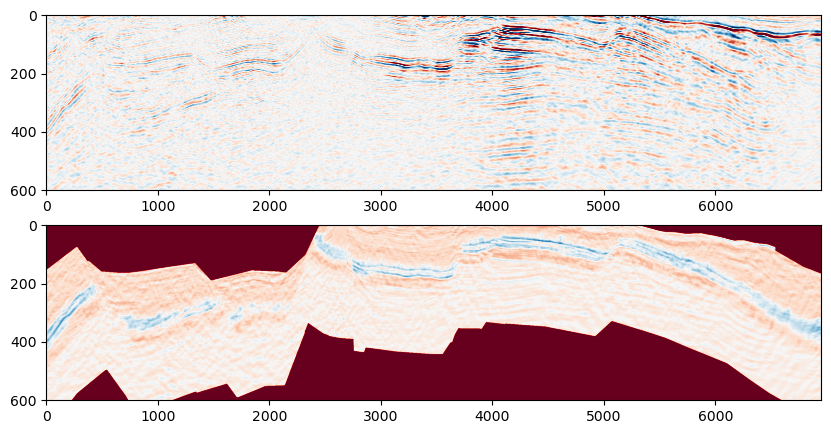

In [21]:
clip_percentile = 99
vm = np.percentile(seismic_dataset[0], clip_percentile)

plt.figure(figsize = (10,5))
plt.subplot(2, 1, 1)
plt.imshow(seismic_dataset[3], cmap = "RdBu", aspect = 'auto', vmin = -vm, vmax = vm)
plt.subplot(2, 1, 2)
plt.imshow(acoustic_impedance_dataset[3], cmap = "RdBu", aspect = 'auto')

# Augmenting dataset. Creating patches using emp

In [26]:
from empatches import EMPatches

emp = EMPatches()

patches_seismic = []
for a in seismic_dataset[0:5]:
    img_patches, indices = emp.extract_patches(a, patchsize=256, overlap=0.5)
    img_patches = np.concatenate(img_patches)
    img_patches = tf.reshape(img_patches, [int(img_patches.shape[0]/256), 256, 256])
    patches_seismic.append(img_patches)
patches_seismic = tf.expand_dims(np.concatenate(patches_seismic, axis=0),-1)
print(patches_seismic.shape)

# do the same for acoustic impedance dataset
patches_acoustic_impedance = []
for a in acoustic_impedance_dataset[0:5]:
    img_patches, indices = emp.extract_patches(a, patchsize=256, overlap=0.5)
    img_patches = np.concatenate(img_patches)
    img_patches = tf.reshape(img_patches, [int(img_patches.shape[0]/256), 256, 256])
    patches_acoustic_impedance.append(img_patches)
patches_acoustic_impedance = tf.expand_dims(np.concatenate(patches_acoustic_impedance, axis=0),-1)
print(patches_acoustic_impedance.shape)

# do the same for bulk modulus dataset
patches_bulk_modulus = []
for a in bulk_modulus_dataset[0:5]:
    img_patches, indices = emp.extract_patches(a, patchsize=256, overlap=0.5)
    img_patches = np.concatenate(img_patches)
    img_patches = tf.reshape(img_patches, [int(img_patches.shape[0]/256), 256, 256])
    patches_bulk_modulus.append(img_patches)
patches_bulk_modulus = tf.expand_dims(np.concatenate(patches_bulk_modulus, axis=0),-1)
print(patches_bulk_modulus.shape)

# do the same for density dataset
patches_density = []
for a in density_dataset[0:5]:
    img_patches, indices = emp.extract_patches(a, patchsize=256, overlap=0.5)
    img_patches = np.concatenate(img_patches)
    img_patches = tf.reshape(img_patches, [int(img_patches.shape[0]/256), 256, 256])
    patches_density.append(img_patches)
patches_density = tf.expand_dims(np.concatenate(patches_density, axis=0),-1)
print(patches_density.shape)

# do the same for permeability dataset
patches_permeability = []
for a in permeability_dataset[0:5]:
    img_patches, indices = emp.extract_patches(a, patchsize=256, overlap=0.5)
    img_patches = np.concatenate(img_patches)
    img_patches = tf.reshape(img_patches, [int(img_patches.shape[0]/256), 256, 256])
    patches_permeability.append(img_patches)
patches_permeability = tf.expand_dims(np.concatenate(patches_permeability, axis=0),-1)
print(patches_permeability.shape)

# # do the same for poisson ratio dataset
patches_poissonratio = []
for a in poissonratio_dataset[0:5]:
    img_patches, indices = emp.extract_patches(a, patchsize=256, overlap=0.5)
    img_patches = np.concatenate(img_patches)
    img_patches = tf.reshape(img_patches, [int(img_patches.shape[0]/256), 256, 256])
    patches_poissonratio.append(img_patches)
patches_poissonratio = tf.expand_dims(np.concatenate(patches_poissonratio, axis=0),-1)
print(patches_poissonratio.shape)

# # # do the same for porosity dataset
patches_porosity = []
for a in porosity_dataset[0:5]:
    img_patches, indices = emp.extract_patches(a, patchsize=256, overlap=0.5)
    img_patches = np.concatenate(img_patches)
    img_patches = tf.reshape(img_patches, [int(img_patches.shape[0]/256), 256, 256])
    patches_porosity.append(img_patches)
patches_porosity = tf.expand_dims(np.concatenate(patches_porosity, axis=0),-1)
print(patches_porosity.shape)

(1008, 256, 256, 1)
(1008, 256, 256, 1)
(1008, 256, 256, 1)
(1008, 256, 256, 1)
(1008, 256, 256, 1)
(1008, 256, 256, 1)
(1008, 256, 256, 1)


In [27]:
# remove the patches with too many zeros
# https://stackoverflow.com/questions/71939370/what-can-be-a-faster-way-to-iterate-through-the-pixels-of-an-image
indices_without_zero = []
for i in range(0, len(tf.squeeze(patches_acoustic_impedance))):
    image = tf.squeeze(patches_acoustic_impedance)[i]
    x,y = np.where(image == 0)   # find the number of pixels with background
    ratio_background = len(x)/(image.shape[1]*image.shape[0]) # get ratio
    if ratio_background < 0.25:
        indices_without_zero.append(i)  # only keep indices that have less background
indices_without_zero = np.array(indices_without_zero)
indices_without_zero[0:3] # to check if it outputs something

array([ 4,  5, 10])

In [28]:
no_background_seismic = np.asarray(patches_seismic)[indices_without_zero]  # seismic
no_background_ai = np.asarray(patches_acoustic_impedance)[indices_without_zero] # acoustic impedance
no_background_bulk_modulus = np.asarray(patches_bulk_modulus)[indices_without_zero] # bulk modulus
no_background_density = np.asarray(patches_density)[indices_without_zero] # density
no_background_permeability = np.asarray(patches_permeability)[indices_without_zero] # permeability
no_background_poissonratio = np.asarray(patches_poissonratio)[indices_without_zero] # poisson ratio
no_background_porosity = np.asarray(patches_porosity)[indices_without_zero] # porosity

#######################################################################################################
# flip seismic
updated = tf.image.flip_left_right(no_background_seismic)
resized_seismic = np.concatenate([no_background_seismic, updated], axis=0)
print(resized_seismic.shape)

# flip acoustic impedance
updated = tf.image.flip_left_right(no_background_ai)
resized_acoustic_impedance = np.concatenate([no_background_ai, updated], axis=0)

# flip bulk modulus
updated = tf.image.flip_left_right(no_background_bulk_modulus)
resized_bulk_modulus = np.concatenate([no_background_bulk_modulus, updated], axis=0)

# flip density
updated = tf.image.flip_left_right(no_background_density)
resized_density = np.concatenate([no_background_density, updated], axis=0)

# flip permeability
updated = tf.image.flip_left_right(no_background_permeability)
resized_permeability = np.concatenate([no_background_permeability, updated], axis=0)

# # flip porosity
updated = tf.image.flip_left_right(no_background_porosity)
resized_porosity = np.concatenate([no_background_porosity, updated], axis=0)

# flip poisson ratio
updated = tf.image.flip_left_right(no_background_poissonratio)
resized_poissonratio = np.concatenate([no_background_poissonratio, updated], axis=0)

(570, 256, 256, 1)


In [29]:
del patches_seismic
del indices_without_zero
del patches_acoustic_impedance
del patches_bulk_modulus
del patches_density
del updated
del no_background_seismic
del no_background_ai
del no_background_bulk_modulus
del no_background_density

In [30]:
# scaling factor standardscaler
print('seismic')
scaled_seismic = np.float32(resized_seismic - np.mean(resized_seismic))/np.std(resized_seismic)

print('acoustic impedance')
scaled_acousticimpedance = np.float32(resized_acoustic_impedance - np.mean(resized_acoustic_impedance))/np.std(resized_acoustic_impedance)

print('bulk modulus')
scaled_bulk_modulus = np.float32(resized_bulk_modulus - np.mean(resized_bulk_modulus))/np.std(resized_bulk_modulus)

print('density')
scaled_density = np.float32(resized_density - np.mean(resized_density))/np.std(resized_density)

print('permeability')
scaled_permeability = np.float32(resized_permeability - np.mean(resized_permeability))/np.std(resized_permeability)

print('poisson ratio')
scaled_poissonratio = np.float32(resized_poissonratio - np.mean(resized_poissonratio))/np.std(resized_poissonratio)

print('porosity')
scaled_porosity = np.float32(resized_porosity - np.mean(resized_porosity))/np.std(resized_porosity)

seismic
acoustic impedance
bulk modulus
density
permeability
poisson ratio
porosity


# Model building

In [32]:
from tensorflow.keras import layers, regularizers
# Create an L2 regularizer
l2_regularizer = regularizers.l2(0.01)

def regularized_loss_masked(y_true, y_pred):
    # Calculate the Mean Squared Error
    loss = K.mean(K.square(y_pred*K.cast(y_true> tf.reduce_min(y_true), "float32") - y_true), axis = -1)

    # Add the L2 regularization
    for layer in model5.layers:
        if hasattr(layer, 'kernel'):
            loss += l2_regularizer(layer.kernel)

    return loss

# https://stackoverflow.com/questions/41707621/keras-mean-squared-error-loss-layer
# https://stackoverflow.com/questions/57037128/keras-custom-loss-ignore-zero-labels

In [33]:
# Define a custom R-squared metric
def r_squared(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

In [37]:
# def unet(input_shape, num_channels):
def unet():
    inputs = Input(shape=(None, None, num_channels))

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Center
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    # Output layer with linear activation for regression
    acousticimpedance = Conv2D(1, (1, 1), activation='linear', 
                               name = 'acoustic_impedance')(conv9)
    bulkmodulus = Conv2D(1, (1,1), activation = 'linear', 
                         name = 'bulk_modulus')(conv9)
    density = Conv2D(1, (1,1), activation = 'linear', 
                     name = 'density')(conv9)
    permeability = Conv2D(1, (1,1), activation = 'linear', 
                          name = 'permeability')(conv9)
    poissonratio = Conv2D(1, (1,1), activation = 'linear', 
                          name = 'poisson_ratio')(conv9)
    porosity = Conv2D(1, (1,1), activation = 'linear',
                     name = 'porosity')(conv9)

    model = Model(inputs=[inputs], 
                  outputs= [
                  acousticimpedance,
                            bulkmodulus,
                             density,
                             permeability,
                            poissonratio,
                            porosity
                            ])

    return model

num_channels = 1  # Set the number of input channels (RGB images have 3 channels)

model5 = unet()
model5.compile(optimizer = Adam(learning_rate = 1e-3), loss = regularized_loss_masked, metrics = ['MAE',r_squared])
model5.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   320         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   9248        ['conv2d[0][0]']                 
                                32)                                                           

                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (None, None, None,   0          ['conv2d_15[0][0]']              
                                64)                                                               
                                                                                                  
 concatenate_3 (Concatenate)    (None, None, None,   0           ['up_sampling2d_3[0][0]',        
                                96)                               'conv2d_1[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, None, None,   27680       ['concatenate_3[0][0]']          
                                32)                                                               
                                                                                                  
 conv2d_17

In [38]:
%%time
history5 = model5.fit(scaled_seismic, 
                    [scaled_acousticimpedance,
                      scaled_bulk_modulus, 
                     scaled_density, 
                      scaled_permeability, scaled_poissonratio, 
                     scaled_porosity,
                     ], 
                    batch_size = 8, epochs = 60, 
                    verbose = 1, shuffle = True,  validation_split = 0.2)

Epoch 1/40
57/57 [==============================] - 429s 6s/step - loss: 39.0676 - acoustic_impedance_loss: 6.6020 - bulk_modulus_loss: 6.5438 - density_loss: 6.4793 - permeability_loss: 6.5112 - poisson_ratio_loss: 6.8097 - porosity_loss: 6.1216 - acoustic_impedance_MAE: 0.6331 - acoustic_impedance_r_squared: 0.1901 - bulk_modulus_MAE: 0.8723 - bulk_modulus_r_squared: -0.2400 - density_MAE: 0.9230 - density_r_squared: -0.4980 - permeability_MAE: 1.1384 - permeability_r_squared: -1.4451 - poisson_ratio_MAE: 0.9361 - poisson_ratio_r_squared: -0.0142 - porosity_MAE: 2.0312 - porosity_r_squared: -4.2653 - val_loss: 8.0757 - val_acoustic_impedance_loss: 1.5775 - val_bulk_modulus_loss: 1.2599 - val_density_loss: 1.1989 - val_permeability_loss: 1.5362 - val_poisson_ratio_loss: 1.6823 - val_porosity_loss: 0.8209 - val_acoustic_impedance_MAE: 0.7232 - val_acoustic_impedance_r_squared: 0.1451 - val_bulk_modulus_MAE: 0.9475 - val_bulk_modulus_r_squared: -0.4126 - val_density_MAE: 0.9080 - val_de

Epoch 8/40
57/57 [==============================] - 341s 6s/step - loss: 4.1055 - acoustic_impedance_loss: 0.7269 - bulk_modulus_loss: 0.7640 - density_loss: 0.6701 - permeability_loss: 0.6396 - poisson_ratio_loss: 1.0413 - porosity_loss: 0.2636 - acoustic_impedance_MAE: 0.5752 - acoustic_impedance_r_squared: 0.3269 - bulk_modulus_MAE: 0.8430 - bulk_modulus_r_squared: -0.1901 - density_MAE: 0.9047 - density_r_squared: -0.6762 - permeability_MAE: 1.2458 - permeability_r_squared: -1.9994 - poisson_ratio_MAE: 0.9219 - poisson_ratio_r_squared: 0.0123 - porosity_MAE: 2.2563 - porosity_r_squared: -5.0217 - val_loss: 4.5530 - val_acoustic_impedance_loss: 0.9115 - val_bulk_modulus_loss: 0.7766 - val_density_loss: 0.6528 - val_permeability_loss: 0.9083 - val_poisson_ratio_loss: 1.0280 - val_porosity_loss: 0.2758 - val_acoustic_impedance_MAE: 0.6378 - val_acoustic_impedance_r_squared: 0.2759 - val_bulk_modulus_MAE: 0.8310 - val_bulk_modulus_r_squared: -0.0277 - val_density_MAE: 0.8742 - val_dens

Epoch 15/40
57/57 [==============================] - 332s 6s/step - loss: 3.9322 - acoustic_impedance_loss: 0.6973 - bulk_modulus_loss: 0.7473 - density_loss: 0.6437 - permeability_loss: 0.5947 - poisson_ratio_loss: 1.0143 - porosity_loss: 0.2350 - acoustic_impedance_MAE: 0.5704 - acoustic_impedance_r_squared: 0.3361 - bulk_modulus_MAE: 0.8254 - bulk_modulus_r_squared: -0.1806 - density_MAE: 0.8981 - density_r_squared: -0.6990 - permeability_MAE: 1.1858 - permeability_r_squared: -2.0587 - poisson_ratio_MAE: 0.9136 - poisson_ratio_r_squared: 0.0183 - porosity_MAE: 2.2716 - porosity_r_squared: -5.0848 - val_loss: 4.3328 - val_acoustic_impedance_loss: 0.8794 - val_bulk_modulus_loss: 0.7141 - val_density_loss: 0.6352 - val_permeability_loss: 0.8386 - val_poisson_ratio_loss: 1.0251 - val_porosity_loss: 0.2405 - val_acoustic_impedance_MAE: 0.6353 - val_acoustic_impedance_r_squared: 0.2891 - val_bulk_modulus_MAE: 0.8406 - val_bulk_modulus_r_squared: -0.1169 - val_density_MAE: 0.9367 - val_den

Epoch 22/40
57/57 [==============================] - 346s 6s/step - loss: 3.8742 - acoustic_impedance_loss: 0.6864 - bulk_modulus_loss: 0.7318 - density_loss: 0.6367 - permeability_loss: 0.5834 - poisson_ratio_loss: 1.0039 - porosity_loss: 0.2320 - acoustic_impedance_MAE: 0.5670 - acoustic_impedance_r_squared: 0.3400 - bulk_modulus_MAE: 0.8312 - bulk_modulus_r_squared: -0.1843 - density_MAE: 0.8996 - density_r_squared: -0.6895 - permeability_MAE: 1.1424 - permeability_r_squared: -1.9489 - poisson_ratio_MAE: 0.9168 - poisson_ratio_r_squared: 0.0286 - porosity_MAE: 2.2469 - porosity_r_squared: -4.9406 - val_loss: 4.2615 - val_acoustic_impedance_loss: 0.8660 - val_bulk_modulus_loss: 0.7078 - val_density_loss: 0.6292 - val_permeability_loss: 0.7984 - val_poisson_ratio_loss: 1.0228 - val_porosity_loss: 0.2373 - val_acoustic_impedance_MAE: 0.6330 - val_acoustic_impedance_r_squared: 0.2989 - val_bulk_modulus_MAE: 0.8465 - val_bulk_modulus_r_squared: -0.1290 - val_density_MAE: 0.9294 - val_den

Epoch 29/40
57/57 [==============================] - 346s 6s/step - loss: 3.8573 - acoustic_impedance_loss: 0.6944 - bulk_modulus_loss: 0.7248 - density_loss: 0.6317 - permeability_loss: 0.5779 - poisson_ratio_loss: 1.0067 - porosity_loss: 0.2220 - acoustic_impedance_MAE: 0.5739 - acoustic_impedance_r_squared: 0.3294 - bulk_modulus_MAE: 0.8253 - bulk_modulus_r_squared: -0.1591 - density_MAE: 0.9038 - density_r_squared: -0.7392 - permeability_MAE: 1.1229 - permeability_r_squared: -1.8613 - poisson_ratio_MAE: 0.9166 - poisson_ratio_r_squared: 0.0209 - porosity_MAE: 2.2855 - porosity_r_squared: -5.1539 - val_loss: 4.2334 - val_acoustic_impedance_loss: 0.8610 - val_bulk_modulus_loss: 0.6882 - val_density_loss: 0.6201 - val_permeability_loss: 0.7804 - val_poisson_ratio_loss: 1.0486 - val_porosity_loss: 0.2351 - val_acoustic_impedance_MAE: 0.6262 - val_acoustic_impedance_r_squared: 0.2983 - val_bulk_modulus_MAE: 0.8664 - val_bulk_modulus_r_squared: -0.2061 - val_density_MAE: 0.8794 - val_den

Epoch 36/40
57/57 [==============================] - 362s 6s/step - loss: 3.8258 - acoustic_impedance_loss: 0.6831 - bulk_modulus_loss: 0.7202 - density_loss: 0.6299 - permeability_loss: 0.5745 - poisson_ratio_loss: 0.9940 - porosity_loss: 0.2241 - acoustic_impedance_MAE: 0.5678 - acoustic_impedance_r_squared: 0.3387 - bulk_modulus_MAE: 0.8348 - bulk_modulus_r_squared: -0.2030 - density_MAE: 0.8977 - density_r_squared: -0.7065 - permeability_MAE: 1.1432 - permeability_r_squared: -2.1931 - poisson_ratio_MAE: 0.9129 - poisson_ratio_r_squared: 0.0349 - porosity_MAE: 2.2877 - porosity_r_squared: -5.1804 - val_loss: 4.2287 - val_acoustic_impedance_loss: 0.8608 - val_bulk_modulus_loss: 0.6930 - val_density_loss: 0.6167 - val_permeability_loss: 0.7966 - val_poisson_ratio_loss: 1.0289 - val_porosity_loss: 0.2327 - val_acoustic_impedance_MAE: 0.6285 - val_acoustic_impedance_r_squared: 0.2971 - val_bulk_modulus_MAE: 0.8519 - val_bulk_modulus_r_squared: -0.1617 - val_density_MAE: 0.8842 - val_den

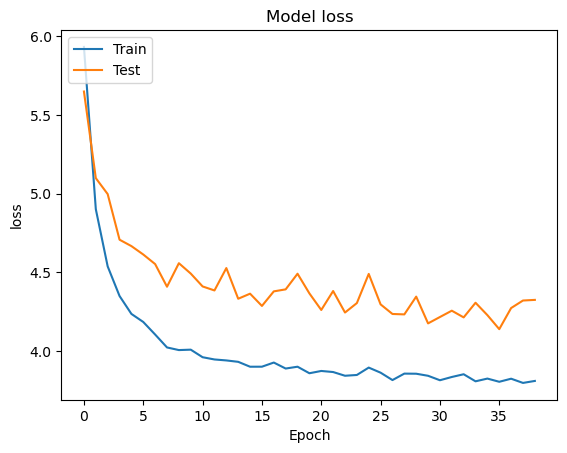

In [39]:
#Saving our predictions in the directory 'preds'
plt.plot(history5.history['loss'][1:])
plt.plot(history5.history['val_loss'][1:])   ######################
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [42]:
pd.DataFrame.from_dict(history5.history).to_csv(current_dir + r"/dataset_models/history_post_stack_model1.csv",index=False)

In [43]:
# saving model
model5.save(current_dir + r"/dataset_models/post_stack_model1")

INFO:tensorflow:Assets written to: C:\Users\jkuhn\Documents\organized\geohackathon\2023/dataset_models/post_stack_model1\assets


INFO:tensorflow:Assets written to: C:\Users\jkuhn\Documents\organized\geohackathon\2023/dataset_models/post_stack_model1\assets


In [48]:
# # #loading model
model5 = tf.keras.models.load_model(current_dir + r"/dataset_models/model_masked",
                                   custom_objects = {"regularized_loss_masked" : regularized_loss_masked, 
                                                     "r_squared":r_squared})

ValueError: Unknown loss function: 'regularized_loss_masked'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [49]:
history = pd.read_csv(current_dir + r"/dataset_models/history_model_masked.csv")

<Axes: title={'center': 'Adjusted r_squared vs epoch'}, xlabel='Epoch', ylabel='Adjusted r-squared'>

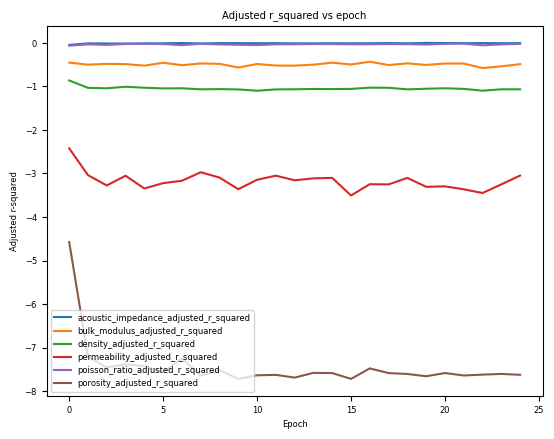

In [50]:
plt.rcParams.update({'font.size': 6})
history[['acoustic_impedance_adjusted_r_squared',
        'bulk_modulus_adjusted_r_squared','density_adjusted_r_squared',
        'permeability_adjusted_r_squared','poisson_ratio_adjusted_r_squared',
        'porosity_adjusted_r_squared']].plot(xlabel = 'Epoch',
                                                 ylabel = 'Adjusted r-squared',
                                                 title = 'Adjusted r_squared vs epoch')

# Prediction

In [86]:
from empatches import EMPatches

img = seismic_dataset[6]
img = (img - np.mean(resized_seismic))/np.std(resized_seismic)
acous = acoustic_impedance_dataset[6]
acous[acous == 0] = np.nan
acous = (acous - np.mean(resized_acoustic_impedance))/np.std(resized_acoustic_impedance)

bm = bulk_modulus_dataset[6]
bm[bm == 0] = np.nan
bm = (bm - np.mean(resized_bulk_modulus))/np.std(resized_bulk_modulus)

density = density_dataset[6]
density[density == 0] = np.nan
density = (density - np.mean(resized_density))/np.std(resized_density)

porosity = porosity_dataset[6]
porosity[porosity == 0] = np.nan
porosity = (porosity - np.mean(resized_porosity))/np.std(resized_porosity)

permeability = permeability_dataset[6]
permeability[permeability == 0] = np.nan
permeability = (permeability - np.mean(resized_permeability))/np.std(resized_permeability)

poisson_ratio = poissonratio_dataset[6]
poisson_ratio[poisson_ratio == 0] = np.nan
poisson_ratio = (poisson_ratio - np.mean(resized_poissonratio))/np.std(resized_poissonratio)

emp = EMPatches()
img_patches, indices = emp.extract_patches(img, patchsize=256, overlap=0.1)
img_patches = np.concatenate(img_patches)
img_patches = tf.reshape(img_patches, [int(img_patches.shape[0]/256), 256, 256])
img_patches = tf.expand_dims(img_patches,-1)
img_patches.shape

TensorShape([39, 256, 256, 1])

In [87]:
prediction5 = model5.predict(img_patches)

2/2 [==============================] - 5s 845ms/step


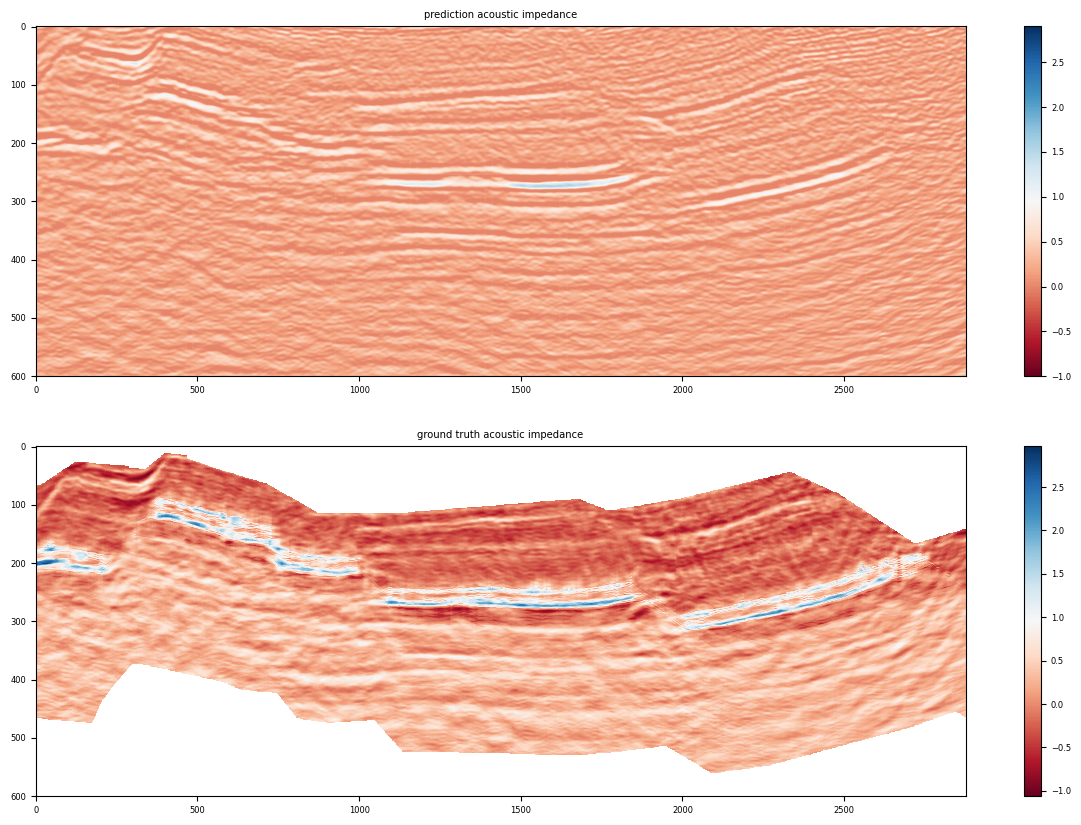

In [99]:
plt.figure(figsize = (15,10))
plt.subplot(2, 1, 1)
prediction6 = emp.merge_patches(prediction5[0], indices, mode='max')
# plt.imshow(prediction6, cmap = "RdBu", aspect = 'auto', vmin = 0.35, vmax = 1.2)
plt.imshow(prediction6, cmap = "RdBu", aspect = 'auto', vmin = -1, vmax = 2.9)

cbar = plt.colorbar()
plt.title('prediction acoustic impedance')
plt.subplot(2, 1, 2)
plt.title('ground truth acoustic impedance')
# plt.imshow(density, cmap = "RdBu", aspect = 'auto', vmin = 0.2, vmax = 2.1)
plt.imshow(acous, cmap = "RdBu", aspect = 'auto')
cbar = plt.colorbar()

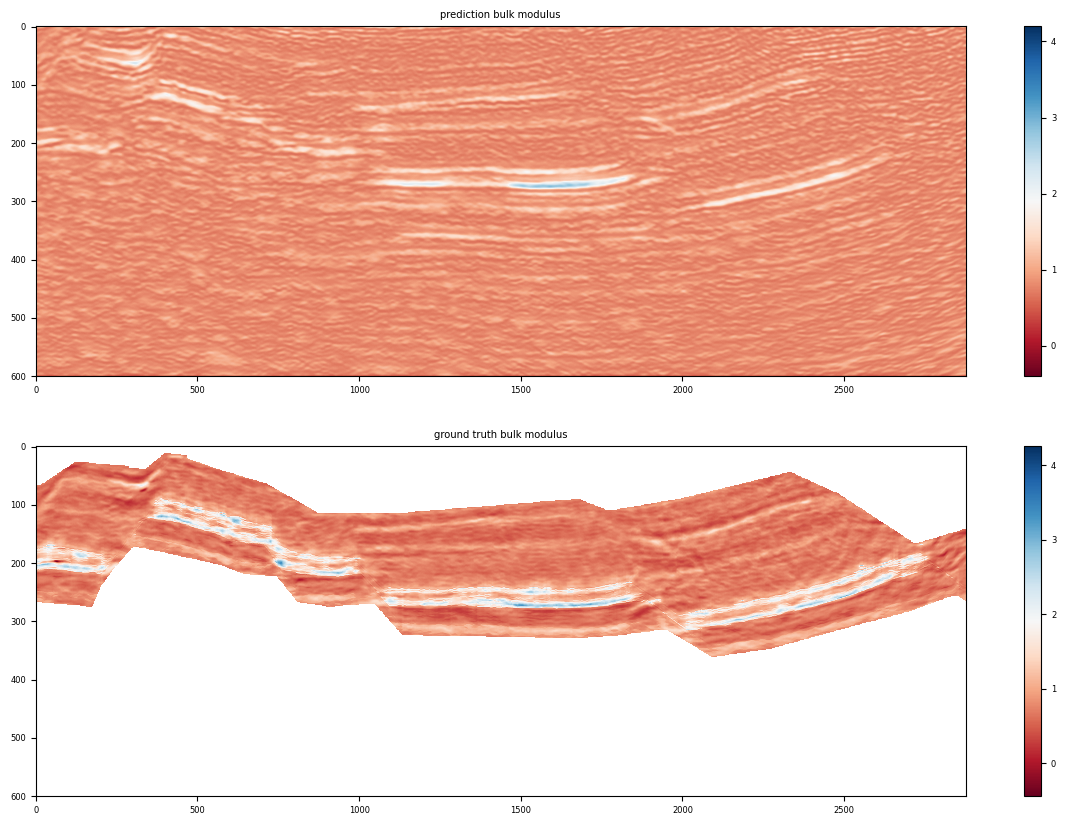

In [105]:
plt.figure(figsize = (15,10))
plt.subplot(2, 1, 1)
prediction6 = emp.merge_patches(prediction5[1], indices, mode='max')
# plt.imshow(prediction6, cmap = "RdBu", aspect = 'auto', vmin = 0.35, vmax = 1.2)
plt.imshow(prediction6, cmap = "RdBu", aspect = 'auto', vmin = -0.4, vmax = 4.2)

cbar = plt.colorbar()
plt.title('prediction bulk modulus')
plt.subplot(2, 1, 2)
plt.title('ground truth bulk modulus')
# plt.imshow(density, cmap = "RdBu", aspect = 'auto', vmin = 0.2, vmax = 2.1)
plt.imshow(bm, cmap = "RdBu", aspect = 'auto')
cbar = plt.colorbar()

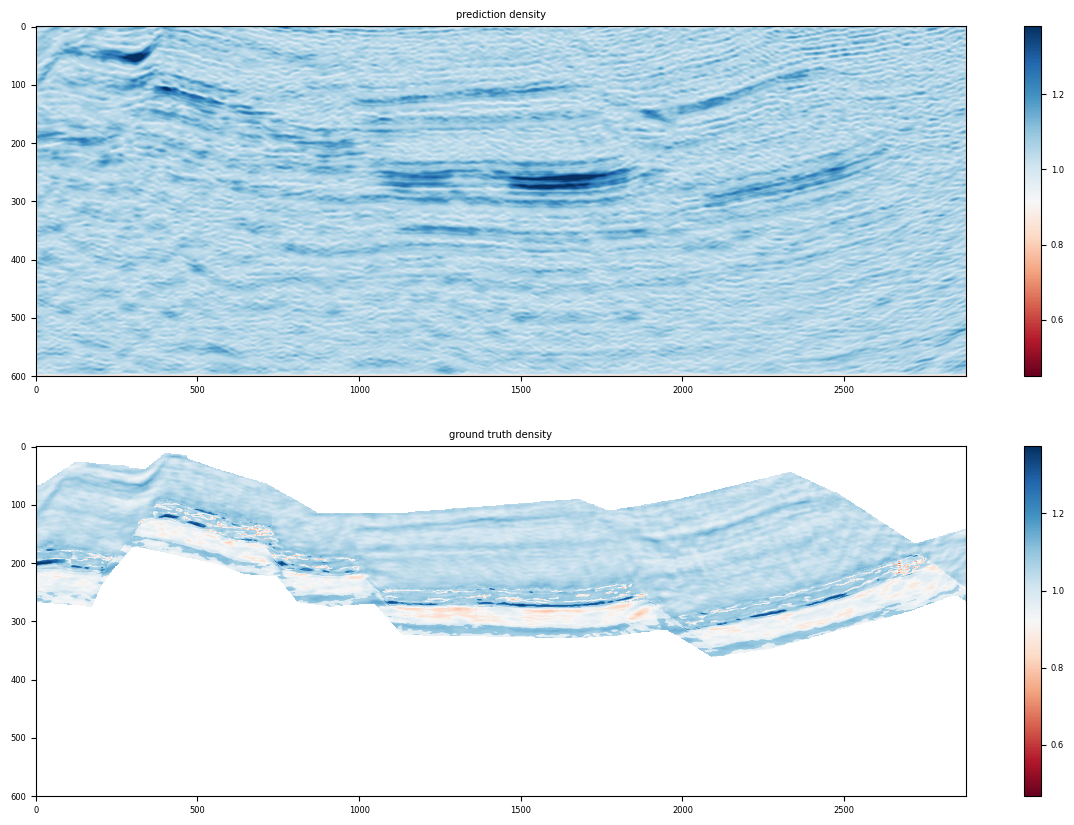

In [100]:
plt.figure(figsize = (15,10))
plt.subplot(2, 1, 1)
prediction6 = emp.merge_patches(prediction5[2], indices, mode='max')
plt.imshow(prediction6, cmap = "RdBu", aspect = 'auto', vmin = 0.45, vmax = 1.38)
# plt.imshow(prediction6, cmap = "RdBu", aspect = 'auto')

cbar = plt.colorbar()
plt.title('prediction density')
plt.subplot(2, 1, 2)
plt.title('ground truth density')
# plt.imshow(density, cmap = "RdBu", aspect = 'auto', vmin = 0.2, vmax = 2.1)
plt.imshow(density, cmap = "RdBu", aspect = 'auto')
cbar = plt.colorbar()

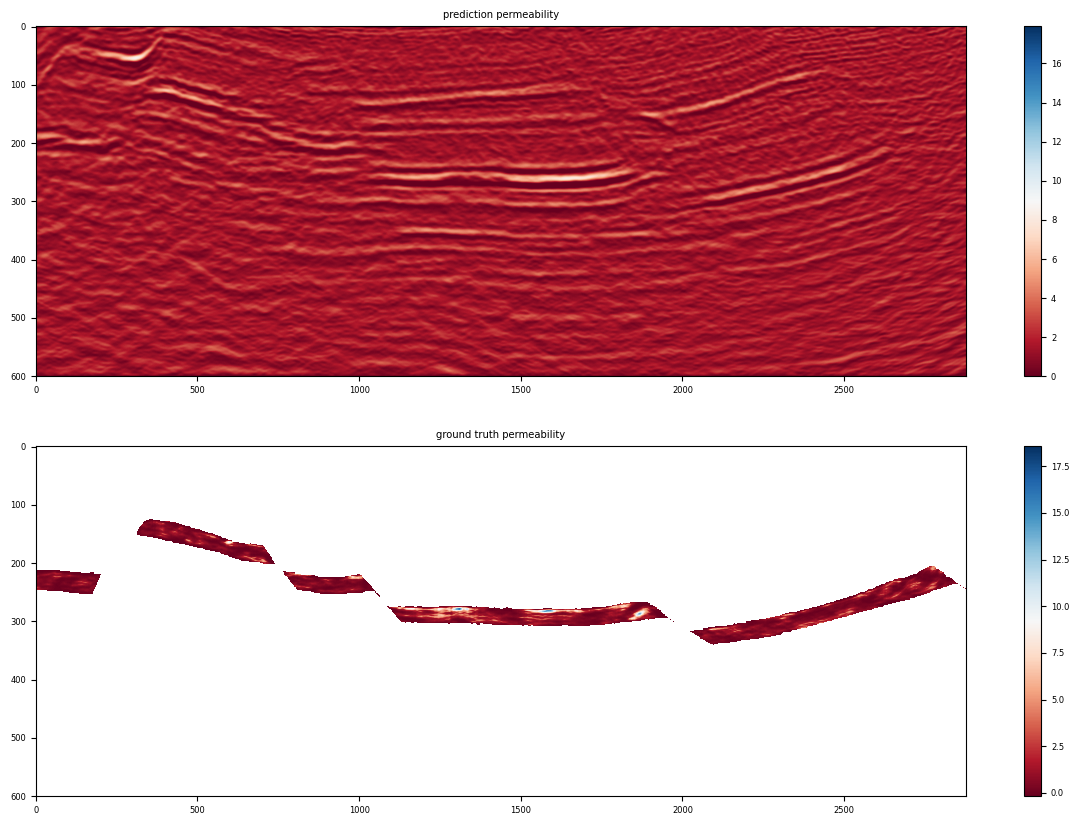

In [101]:
plt.figure(figsize = (15,10))
plt.subplot(2, 1, 1)
prediction6 = emp.merge_patches(prediction5[3], indices, mode='max')
# plt.imshow(prediction6, cmap = "RdBu", aspect = 'auto', vmin = 0.35, vmax = 1.2)
plt.imshow(prediction6, cmap = "RdBu", aspect = 'auto', vmin = 0.0, vmax = 17.9)

cbar = plt.colorbar()
plt.title('prediction permeability')
plt.subplot(2, 1, 2)
plt.title('ground truth permeability')
# plt.imshow(density, cmap = "RdBu", aspect = 'auto', vmin = 0.2, vmax = 2.1)
plt.imshow(permeability, cmap = "RdBu", aspect = 'auto')
cbar = plt.colorbar()

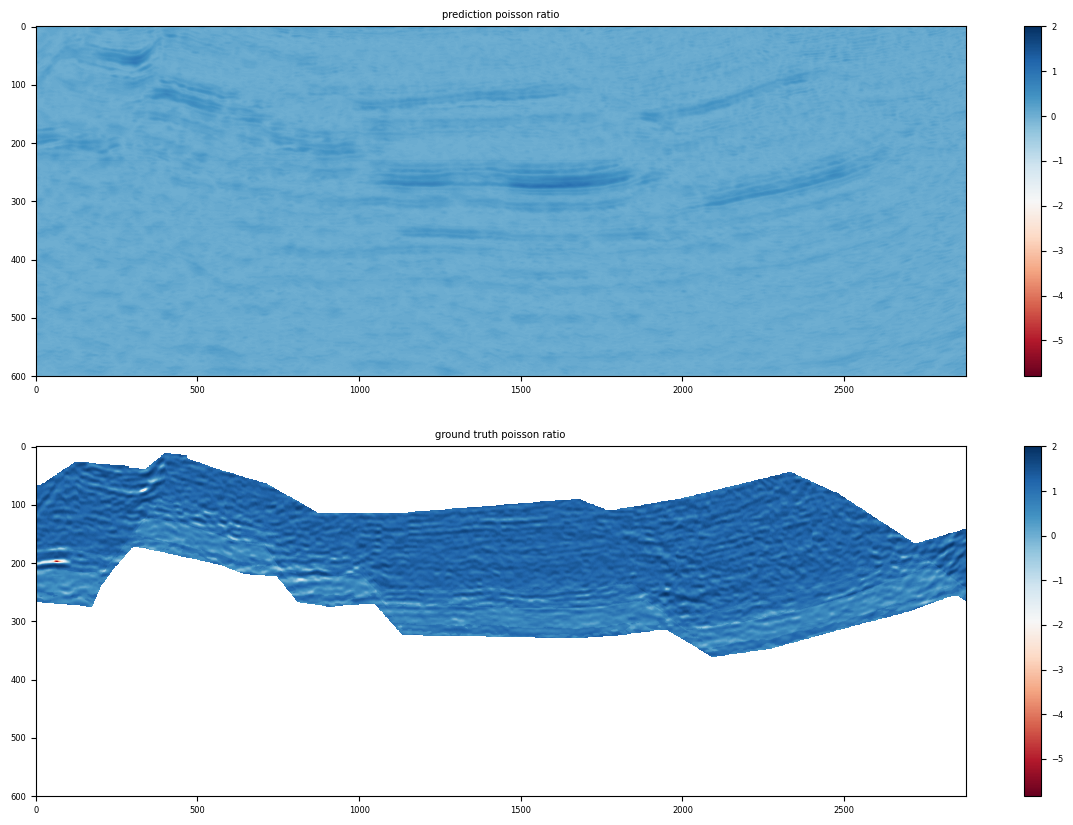

In [102]:
plt.figure(figsize = (15,10))
plt.subplot(2, 1, 1)
prediction6 = emp.merge_patches(prediction5[4], indices, mode='max')
# plt.imshow(prediction6, cmap = "RdBu", aspect = 'auto', vmin = 0.35, vmax = 1.2)
plt.imshow(prediction6, cmap = "RdBu", aspect = 'auto', vmin = -5.8, vmax = 2.0)

cbar = plt.colorbar()
plt.title('prediction poisson ratio')
plt.subplot(2, 1, 2)
plt.title('ground truth poisson ratio')
# plt.imshow(density, cmap = "RdBu", aspect = 'auto', vmin = 0.2, vmax = 2.1)
plt.imshow(poisson_ratio, cmap = "RdBu", aspect = 'auto')
cbar = plt.colorbar()

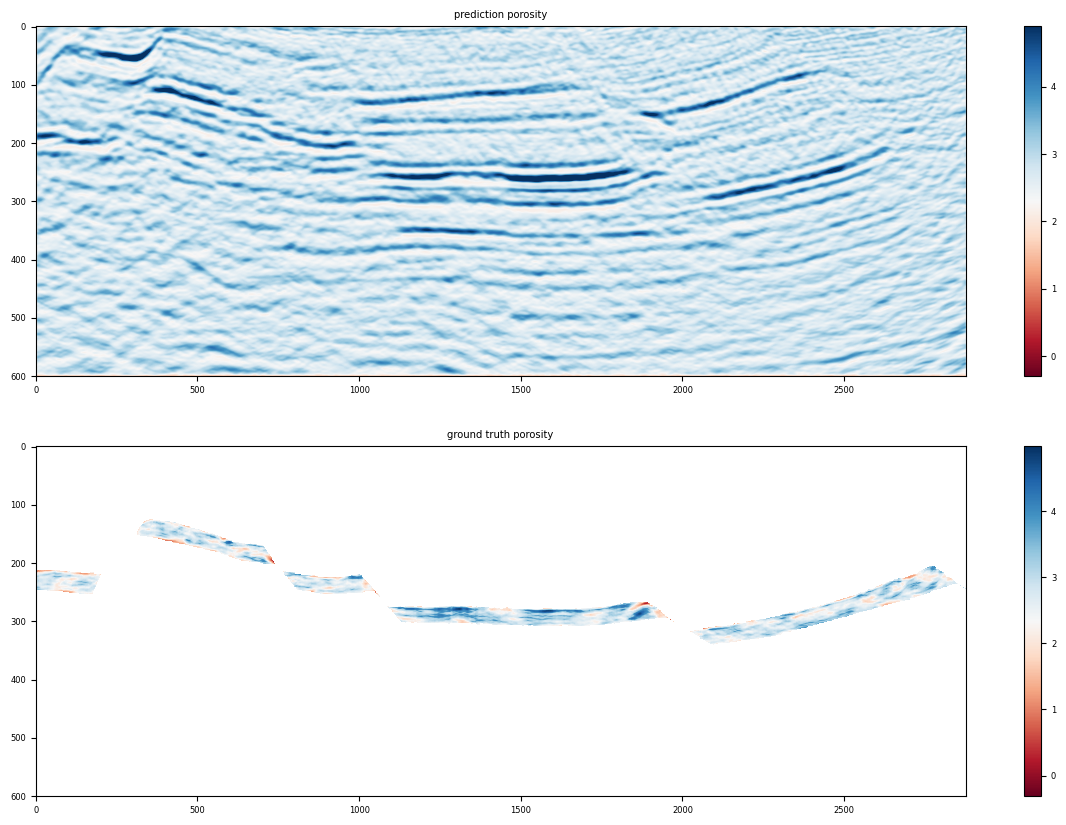

In [103]:
plt.figure(figsize = (15,10))
plt.subplot(2, 1, 1)
prediction6 = emp.merge_patches(prediction5[5], indices, mode='max')
# plt.imshow(prediction6, cmap = "RdBu", aspect = 'auto', vmin = 0.35, vmax = 1.2)
plt.imshow(prediction6, cmap = "RdBu", aspect = 'auto', vmin = -0.3, vmax = 4.9)

cbar = plt.colorbar()
plt.title('prediction porosity')
plt.subplot(2, 1, 2)
plt.title('ground truth porosity')
# plt.imshow(density, cmap = "RdBu", aspect = 'auto', vmin = 0.2, vmax = 2.1)
plt.imshow(porosity, cmap = "RdBu", aspect = 'auto')
cbar = plt.colorbar()